# P2 Milestone

## Was Maslow's Hierarchy of Needs dismantled during the COVID-19 pandemic?
Maslow's Hierarchy of Needs serves as a model for assessing human behavior. We clearly
observed a shift in behavior during the pandemic. Now, we must ask: were the blocks of the
pyramid also rearranged? By analyzing the mobility report alongside Wikipedia searches, we
aim to explore whether the hierarchy of needs remains unchanged or if it needs redefinition. We
will also try to draw a link between the blocks of the pyramid and the mobility patterns. For
example, groceries and pharmacy represent physiological needs, safety needs may include
residential or job security, love and belonging could be related to relationships and
transportation to see loved ones, and esteem can be associated with employment, and
self-actualization. Self-actualization, at the top of Maslow's Hierarchy, involves personal and
professional growth, creativity, and a deeper sense of purpose. This process may lead to a
renewed appreciation for Maslow's work or reveal new insights into human motivation during
these unique times.

![Image Alt Text](maslow.jpg)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from helpers import *
import plotly.express as px
from datetime import datetime
import statsmodels.formula.api as smf

## Regions Dataframe (External Dataframe)

Dataframe containing countries with their region code, and the continent that they're located in. This dataset has been added in order to associate country region codes in the other datasets to their respectove ccontinents. This is particularly useful in order to have more readable graphs in our anlysis.

We start off by keeping only the columns that we need using the '.loc' method. The columns that we are keeping are the countries' names, their corresponding continent (i.e. 'region') as well as their 'alpha-2' region code.

In [2]:
dfRegions=pd.read_csv('DATA/New Data/regions.csv')
dfRegions = dfRegions.loc[:,['name', 'region', 'alpha-2']]
dfRegions

,name,region,alpha-2
0,Afghanistan,Asia,AF
1,Åland Islands,Europe,AX
2,Albania,Europe,AL
3,Algeria,Africa,DZ
4,American Samoa,Oceania,AS
...,...,...,...
244,Wallis and Futuna,Oceania,WF
245,Western Sahara,Africa,EH
246,Yemen,Asia,YE
247,Zambia,Africa,ZM


Splitting the previous dataframe into multiple dataframes, each corresponding to a specififc continent.

In [3]:
# Creating a list of all possible continents
continents = dfRegions['region'].unique()

# Removing the last element of the 'continents' array, since it's a 'nan' value corresponding to antartica, which can be discarded from
# our analysis
continents = continents[:-1]

# Creating an array of dataframes, each corresponding to the previous datafarme, but for only one specific continent
dfsContinents = []
for continent in continents :
    dfsContinents.append(dfRegions[dfRegions['region'] == continent].copy())


## Interventions 

In [4]:
interventions=pd.read_csv('DATA/interventions.csv')
interventions=process_interventions(interventions)
interventions.dtypes
interventions

,lang,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
0,fr,2020-01-24 00:00:00,2020-02-14 00:00:00,2020-03-14 00:00:00,2020-03-13 00:00:00,2020-03-17 00:00:00,2020-03-16 00:00:00,2020-07-02 00:00:00
1,da,2020-02-27 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-12 00:00:00,2020-03-18 00:00:00,2020-03-11 00:00:00,2020-06-05 00:00:00
2,de,2020-01-27 00:00:00,2020-03-09 00:00:00,2020-03-14 00:00:00,2020-03-22 00:00:00,2020-03-22 00:00:00,2020-03-16 00:00:00,2020-07-10 00:00:00
3,it,2020-01-31 00:00:00,2020-02-22 00:00:00,2020-03-05 00:00:00,2020-03-09 00:00:00,2020-03-11 00:00:00,2020-03-11 00:00:00,2020-06-26 00:00:00
4,nl,2020-02-27 00:00:00,2020-03-06 00:00:00,2020-03-11 00:00:00,2020-03-24 00:00:00,NaT,2020-03-16 00:00:00,2020-05-29 00:00:00
5,no,2020-02-26 00:00:00,2020-02-26 00:00:00,2020-03-13 00:00:00,2020-03-12 00:00:00,2020-03-24 00:00:00,2020-03-11 00:00:00,2020-06-04 00:00:00
6,sr,2020-03-06 00:00:00,2020-03-20 00:00:00,2020-03-15 00:00:00,2020-03-21 00:00:00,2020-03-21 00:00:00,2020-03-16 00:00:00,2020-05-02 00:00:00
7,sv,2020-01-31 00:00:00,2020-03-11 00:00:00,2020-03-18 00:00:00,2020-03-12 00:00:00,NaT,2020-03-11 00:00:00,2020-06-05 00:00:00
8,ko,2020-01-20 00:00:00,2020-02-20 00:00:00,2020-02-23 00:00:00,NaT,NaT,2020-02-25 00:00:00,2020-04-15 00:00:00
9,ca,2020-01-31 00:00:00,2020-02-13 00:00:00,2020-03-12 00:00:00,2020-03-08 00:00:00,2020-03-14 00:00:00,2020-03-16 00:00:00,NaT


In [5]:
interventions['Lockdown']
interventions['Lockdown'] = pd.to_datetime(interventions['Lockdown'], format='%Y-%m-%d')
interventions['Public events banned'] = pd.to_datetime(interventions['Public events banned'], format='%Y-%m-%d')
interventions['Mobility'] = pd.to_datetime(interventions['Mobility'], format='%Y-%m-%d')

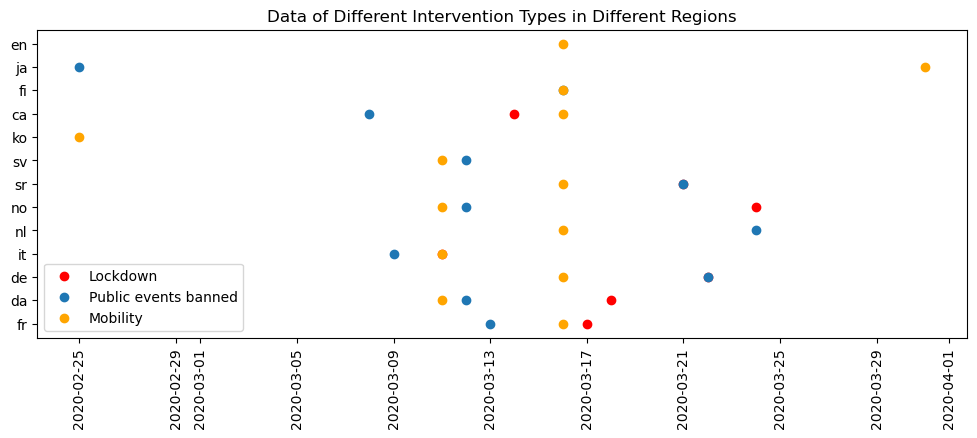

In [6]:
plt.figure(figsize=(12,4))
plt.scatter(interventions['Lockdown'],interventions['lang'],color='red',label='Lockdown')
plt.scatter(interventions['Public events banned'],interventions['lang'],label='Public events banned')
plt.scatter(interventions['Mobility'],interventions['lang'],color='orange',label='Mobility')
plt.legend()
plt.xticks(rotation=90)
plt.title('Data of Different Intervention Types in Different Regions')
plt.show()


In [7]:
interventions

,lang,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
0,fr,2020-01-24 00:00:00,2020-02-14 00:00:00,2020-03-14 00:00:00,2020-03-13,2020-03-17,2020-03-16,2020-07-02 00:00:00
1,da,2020-02-27 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-12,2020-03-18,2020-03-11,2020-06-05 00:00:00
2,de,2020-01-27 00:00:00,2020-03-09 00:00:00,2020-03-14 00:00:00,2020-03-22,2020-03-22,2020-03-16,2020-07-10 00:00:00
3,it,2020-01-31 00:00:00,2020-02-22 00:00:00,2020-03-05 00:00:00,2020-03-09,2020-03-11,2020-03-11,2020-06-26 00:00:00
4,nl,2020-02-27 00:00:00,2020-03-06 00:00:00,2020-03-11 00:00:00,2020-03-24,NaT,2020-03-16,2020-05-29 00:00:00
5,no,2020-02-26 00:00:00,2020-02-26 00:00:00,2020-03-13 00:00:00,2020-03-12,2020-03-24,2020-03-11,2020-06-04 00:00:00
6,sr,2020-03-06 00:00:00,2020-03-20 00:00:00,2020-03-15 00:00:00,2020-03-21,2020-03-21,2020-03-16,2020-05-02 00:00:00
7,sv,2020-01-31 00:00:00,2020-03-11 00:00:00,2020-03-18 00:00:00,2020-03-12,NaT,2020-03-11,2020-06-05 00:00:00
8,ko,2020-01-20 00:00:00,2020-02-20 00:00:00,2020-02-23 00:00:00,NaT,NaT,2020-02-25,2020-04-15 00:00:00
9,ca,2020-01-31 00:00:00,2020-02-13 00:00:00,2020-03-12 00:00:00,2020-03-08,2020-03-14,2020-03-16,NaT


## Topics linked

In [8]:
topics_linked=pd.read_csv('DATA/topics_linked.csv')
topics_linked=process_topics_linked(topics_linked)

In [9]:
topics_agg=topics_linked.select_dtypes(include='int').sum().copy()
topics_agg=topics_agg.sort_values(ascending=False)

In [10]:
topics_agg.describe()

count    6.400000e+01
mean     1.824276e+05
std      2.651203e+05
min      4.301000e+03
25%      3.186950e+04
50%      8.563600e+04
75%      1.809262e+05
max      1.403864e+06
dtype: float64

In [11]:
topics_agg

Culture.Biography.Biography*                1403864
Geography.Regions.Europe.Europe*            1008804
Culture.Media.Media*                         817879
Culture.Sports                               739892
Geography.Regions.Americas.North America     703802
                                             ...   
Geography.Regions.Africa.Western Africa       12143
Geography.Regions.Asia.Central Asia           10441
STEM.Libraries & Information                   8814
Geography.Regions.Africa.Eastern Africa        7192
Geography.Regions.Africa.Central Africa        4301
Length: 64, dtype: int64

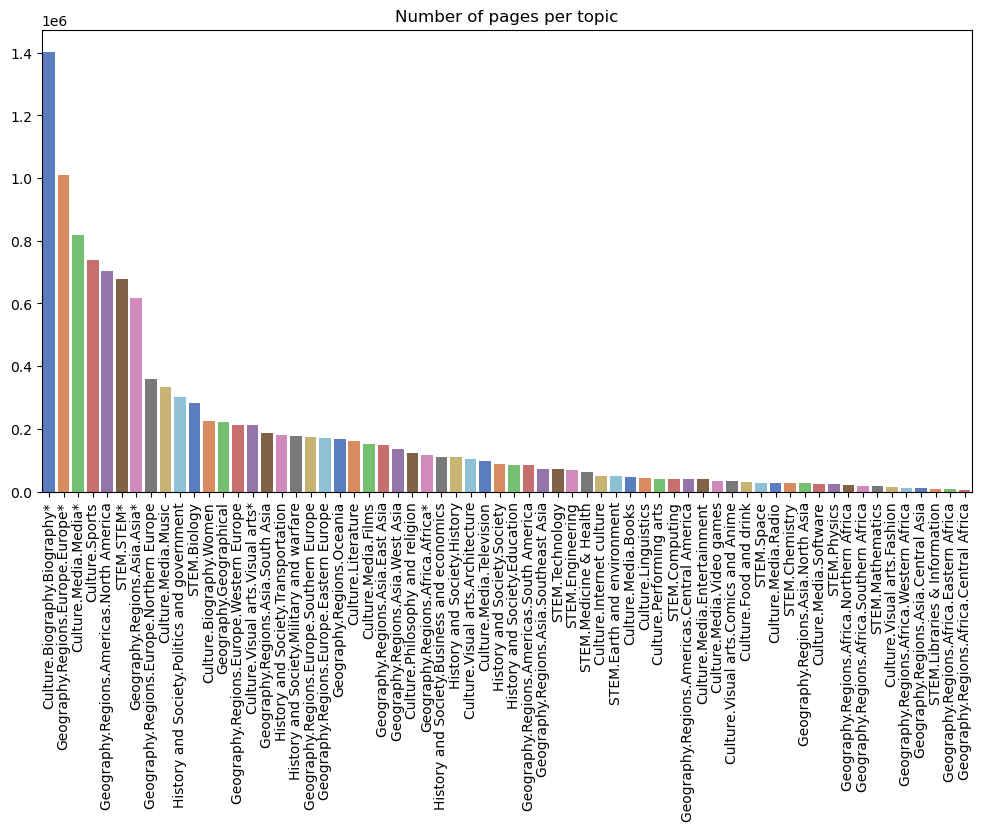

In [12]:
plt.figure(figsize=(12,6))
sns.barplot(x=topics_agg.index, y=topics_agg, palette='muted')
plt.xticks(rotation=90)
plt.title('Number of pages per topic')
plt.show()

Creating an array of the different main groups of topic (Culture, History, ...)

In [13]:
topics_groups = ['Culture', 'Geography', 'History', 'STEM']

Splitting the "topics_agg" dataframe into multiple dataframes, each corresponding to a specific topic group and storing them in the array "dfsTopics".

In [14]:
dfsTopics = [] 
for topic in topics_groups :
    dfsTopics.append(topics_agg[topics_agg.index.str.contains(topic)].copy())

Creating multiple barplots, base on the main topic group.

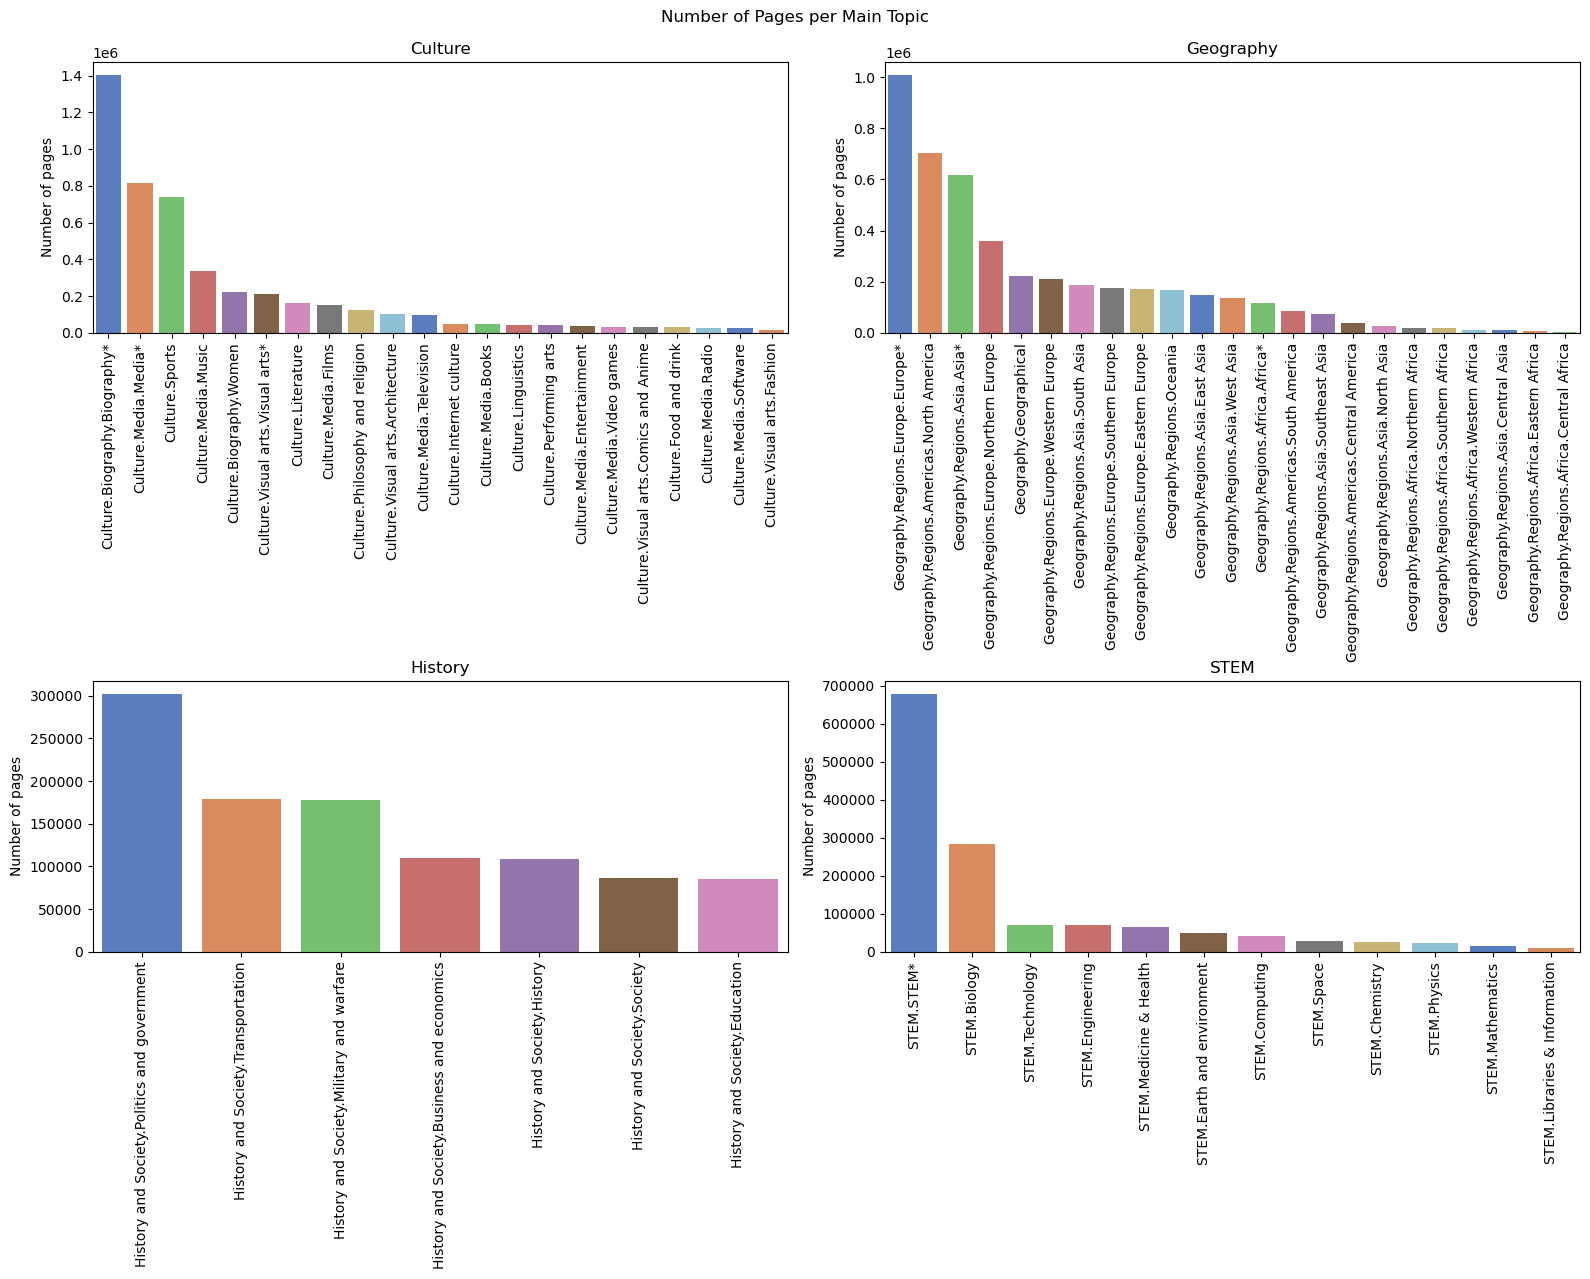

In [15]:
fig, axs= plt.subplots(2,2,sharey=False,sharex=False,figsize=(16,13))
for i, dfTopic in enumerate(dfsTopics) :
    ax = axs[i//2][i%2]
    sns.barplot(x=dfTopic.index, y=dfTopic, palette='muted', ax=ax)
    ax.set_ylabel('Number of pages')
    ax.set_xticklabels(dfTopic.index, rotation=90)
    ax.set_title(topics_groups[i])


plt.tight_layout()

# Fine-tune layout to create more space at the top
plt.subplots_adjust(top=0.94)

plt.suptitle('Number of Pages per Main Topic')
plt.show()

## Aggregated time series

In [16]:
agg_ts=pd.read_json('DATA/aggregated_timeseries.json')
agg_ts


,ja.m,it,da.m,tr,no.m,en,sr,tr.m,en.m,no,...,ko.m,fi.m,sr.m,ja,fr,fi,ca,it.m,sv.m,ko
len,1197788,1594039,256451,346007,516838,6047509,632128,345790,6045654,531478,...,489181,480638,396063,1197856,2195949,481854,642031,1588312,1959446,490314
sum,"{'2018-01-01 00:00:00': 22328288, '2018-01-02 ...","{'2018-01-01 00:00:00': 3338750, '2018-01-02 0...","{'2018-01-01 00:00:00': 765123, '2018-01-02 00...","{'2018-01-01 00:00:00': 407629, '2018-01-02 00...","{'2018-01-01 00:00:00': 715031, '2018-01-02 00...","{'2018-01-01 00:00:00': 86763830, '2018-01-02 ...","{'2018-01-01 00:00:00': 192409, '2018-01-02 00...","{'2018-01-01 00:00:00': 493684, '2018-01-02 00...","{'2018-01-01 00:00:00': 135822131, '2018-01-02...","{'2018-01-01 00:00:00': 224417, '2018-01-02 00...",...,"{'2018-01-01 00:00:00': 1484496, '2018-01-02 0...","{'2018-01-01 00:00:00': 1319053, '2018-01-02 0...","{'2018-01-01 00:00:00': 451383, '2018-01-02 00...","{'2018-01-01 00:00:00': 7828155, '2018-01-02 0...","{'2018-01-01 00:00:00': 6441009, '2018-01-02 0...","{'2018-01-01 00:00:00': 523135, '2018-01-02 00...","{'2018-01-01 00:00:00': 111910, '2018-01-02 00...","{'2018-01-01 00:00:00': 12856884, '2018-01-02 ...","{'2018-01-01 00:00:00': 2383474, '2018-01-02 0...","{'2018-01-01 00:00:00': 819174, '2018-01-02 00..."
covid,"{'len': 30, 'sum': {'2018-01-01 00:00:00': 55,...","{'len': 33, 'sum': {'2018-01-01 00:00:00': 50,...","{'len': 4, 'sum': {'2018-01-01 00:00:00': 0, '...","{'len': 64, 'sum': {'2018-01-01 00:00:00': 1, ...","{'len': 10, 'sum': {'2018-01-01 00:00:00': 7, ...","{'len': 306, 'sum': {'2018-01-01 00:00:00': 57...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 6, '...","{'len': 64, 'sum': {'2018-01-01 00:00:00': 3, ...","{'len': 306, 'sum': {'2018-01-01 00:00:00': 91...","{'len': 10, 'sum': {'2018-01-01 00:00:00': 2, ...",...,"{'len': 113, 'sum': {'2018-01-01 00:00:00': 6,...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 0, '...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 11, ...","{'len': 30, 'sum': {'2018-01-01 00:00:00': 26,...","{'len': 16, 'sum': {'2018-01-01 00:00:00': 62,...","{'len': 9, 'sum': {'2018-01-01 00:00:00': 2, '...","{'len': 49, 'sum': {'2018-01-01 00:00:00': 6, ...","{'len': 33, 'sum': {'2018-01-01 00:00:00': 139...","{'len': 8, 'sum': {'2018-01-01 00:00:00': 19, ...","{'len': 113, 'sum': {'2018-01-01 00:00:00': 3,..."
topics,{'Culture.Biography.Biography*': {'len': 14904...,{'Culture.Biography.Biography*': {'len': 29427...,{'Culture.Biography.Biography*': {'len': 57720...,{'Culture.Biography.Biography*': {'len': 70443...,{'Culture.Biography.Biography*': {'len': 11603...,{'Culture.Biography.Biography*': {'len': 14038...,{'Culture.Biography.Biography*': {'len': 37718...,{'Culture.Biography.Biography*': {'len': 70434...,{'Culture.Biography.Biography*': {'len': 14038...,{'Culture.Biography.Biography*': {'len': 11804...,...,{'Culture.Biography.Biography*': {'len': 75406...,{'Culture.Biography.Biography*': {'len': 10422...,{'Culture.Biography.Biography*': {'len': 37580...,{'Culture.Biography.Biography*': {'len': 14904...,{'Culture.Biography.Biography*': {'len': 38258...,{'Culture.Biography.Biography*': {'len': 10444...,{'Culture.Biography.Biography*': {'len': 10175...,{'Culture.Biography.Biography*': {'len': 29422...,{'Culture.Biography.Biography*': {'len': 14668...,{'Culture.Biography.Biography*': {'len': 75498...


#### Naive look at different topics: case Italy

General Case

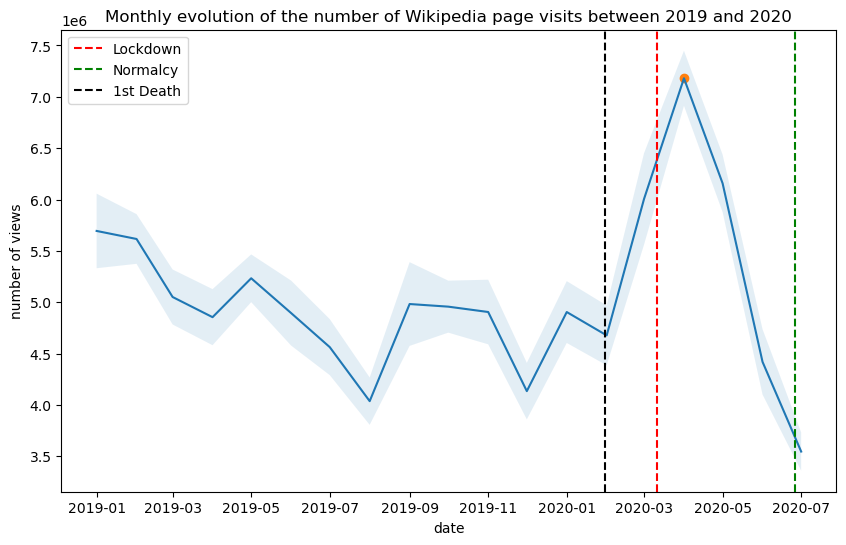

In [17]:
it=process_agg_time_series(agg_ts['it']['sum'])
it=it.loc[it['year'].isin([2020,2019])]
it_means=it.groupby(['year','month'])['sum'].mean().copy()
it_sem=it.groupby(['year','month'])['sum'].sem().copy()
it_means.index=[datetime(e[0], e[1],1) for e in it_means.index]
it_sem.index=[datetime(e[0], e[1],1) for e in it_sem.index]
CI=stats.t.interval(0.95, len(it_means)-1 , loc = it_means, scale = it_sem)
plt.figure(figsize=(10,6))
sns.lineplot(it_means)
plt.axvline(x=[interventions['Lockdown'][3]],color='red', linestyle='--', label='Lockdown')
plt.axvline(x=[interventions['Normalcy'][3]],color='green', linestyle='--', label='Normalcy')
plt.axvline(x=[interventions['1st case'][3]],color='black', linestyle='--', label='1st Death')
plt.fill_between(it_means.index,CI[0],CI[1],alpha=0.12)
plt.scatter(x=it_means.idxmax(),y=it_means.max())
plt.title('Monthly evolution of the number of Wikipedia page visits between 2019 and 2020')
plt.xlabel('date')
plt.ylabel('number of views')
plt.legend()
plt.show()

Specific case

<Figure size 1400x600 with 0 Axes>

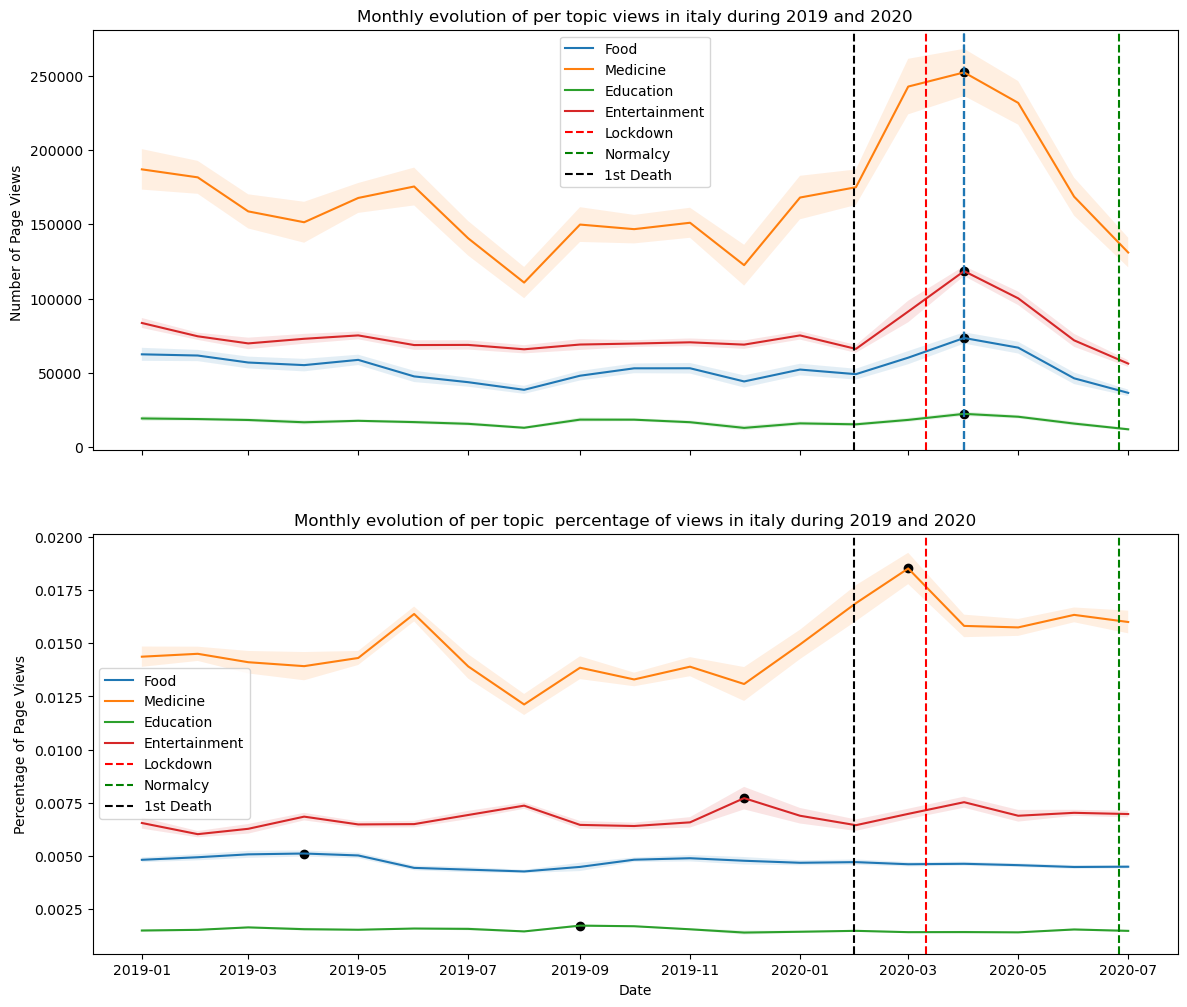

In [18]:
timeseries=[agg_ts['it']['topics']['Culture.Food and drink'],
    agg_ts['it']['topics']['STEM.Medicine & Health'],
    agg_ts['it']['topics']['History and Society.Education'],
    agg_ts['it']['topics']['Culture.Media.Entertainment']]
legends=['Food','Medicine','Education','Entertainment']
plt.figure(figsize=(14,6))
fig,axs=plt.subplots(2,1,figsize=(14,12),sharex=True)

for i,ts in enumerate(timeseries):
    
    df=process_agg_time_series(ts)
    df=df.loc[df['year'].isin([2020,2019])]
    
    df_means=df.groupby(['year','month'])['sum'].mean().copy()
    df_sem=df.groupby(['year','month'])['sum'].sem().copy()
    df_means.index=[datetime(e[0], e[1],1) for e in df_means.index]
    df_sem.index=[datetime(e[0], e[1],1) for e in df_sem.index]
    CI=stats.t.interval(0.95, len(df_means)-1 , loc = df_means, scale = df_sem)
    sns.lineplot(df_means,label=legends[i],ax=axs[0])
    axs[0].fill_between(df_means.index,CI[0],CI[1],alpha=0.12)
    axs[0].scatter(x=df_means.idxmax(),y=df_means.max(),color='black')
    axs[0].axvline(x=df_means.idxmax(), linestyle='--')
    axs[0].set_title('Monthly evolution of per topic views in italy during 2019 and 2020')
    axs[0].set_ylabel('Number of Page Views ')
    axs[0].set_xlabel('Dates')

    
    df_means=df.groupby(['year','month'])['percent'].mean().copy()
    df_sem=df.groupby(['year','month'])['percent'].sem().copy()
    df_means.index=[datetime(e[0], e[1],1) for e in df_means.index]
    df_sem.index=[datetime(e[0], e[1],1) for e in df_sem.index]
    CI=stats.t.interval(0.95, len(df_means)-1 , loc = df_means, scale = df_sem)
    sns.lineplot(df_means,label=legends[i],ax=axs[1])
    axs[1].fill_between(df_means.index,CI[0],CI[1],alpha=0.12)
    axs[1].scatter(x=df_means.idxmax(),y=df_means.max(),color='black')
    axs[1].set_title('Monthly evolution of per topic  percentage of views in italy during 2019 and 2020')
    axs[1].set_ylabel('Percentage of Page Views')   
    axs[1].set_xlabel('Date')    
    
for i in range(2):
    axs[i].axvline(x=[interventions['Lockdown'][3]],color='red', linestyle='--', label='Lockdown')
    axs[i].axvline(x=[interventions['Normalcy'][3]],color='green', linestyle='--', label='Normalcy')
    axs[i].axvline(x=[interventions['1st case'][3]],color='black', linestyle='--', label='1st Death')
    axs[i].legend()

plt.show()

#### Deeper look at how normalcy status affected the searches

##### General number of cases

###### Add  columns that specify the lockdown and normalcy status of italy (1 for lockdown/normalcy 0 otherwise)

In [19]:
it_lockdown_date=interventions['Lockdown'][3]
it_normalcy_date=interventions['Normalcy'][3]
it_first_death=interventions['Normalcy'][3]

In [20]:
it=process_agg_time_series(agg_ts['it']['sum'])
it['Lockdown_status']= np.where(it['date']>=it_lockdown_date,1,0)
it['Normalcy_status']=np.where(it['date']>=it_normalcy_date,1,0)
it

,sum,date,year,month,day,Lockdown_status,Normalcy_status
0,3338750,2018-01-01,2018,1,1,0,0
1,5428428,2018-01-02,2018,1,2,0,0
2,5640812,2018-01-03,2018,1,3,0,0
3,5794860,2018-01-04,2018,1,4,0,0
4,5475376,2018-01-05,2018,1,5,0,0
...,...,...,...,...,...,...,...
938,3796235,2020-07-27,2020,7,27,1,1
939,3609134,2020-07-28,2020,7,28,1,1
940,3460350,2020-07-29,2020,7,29,1,1
941,3676745,2020-07-30,2020,7,30,1,1


In [21]:
model=smf.ols(formula='sum~C(Lockdown_status)+C(Normalcy_status)',data=it)
res=model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    sum   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     117.7
Date:                Sun, 12 Nov 2023   Prob (F-statistic):           2.38e-46
Time:                        18:14:44   Log-Likelihood:                -14329.
No. Observations:                 943   AIC:                         2.866e+04
Df Residuals:                     940   BIC:                         2.868e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                4

##### Specific case (e.g: food and drink)

In [22]:
food_drink=process_agg_time_series(agg_ts['it']['topics']['Culture.Food and drink'])
food_drink['Lockdown_status']= np.where(food_drink['date']>=it_lockdown_date,1,0)
food_drink['Normalcy_status']=np.where(food_drink['date']>=it_normalcy_date,1,0)

In [23]:
model=smf.ols(formula='sum~C(Lockdown_status)+C(Normalcy_status)',data=food_drink)
res=model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    sum   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     62.23
Date:                Sun, 12 Nov 2023   Prob (F-statistic):           4.16e-26
Time:                        18:14:44   Log-Likelihood:                -10270.
No. Observations:                 943   AIC:                         2.055e+04
Df Residuals:                     940   BIC:                         2.056e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                5

In [24]:
model=smf.ols(formula='percent~C(Lockdown_status)+C(Normalcy_status)',data=food_drink)
res=model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                percent   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     51.45
Date:                Sun, 12 Nov 2023   Prob (F-statistic):           6.23e-22
Time:                        18:14:44   Log-Likelihood:                 5905.3
No. Observations:                 943   AIC:                        -1.180e+04
Df Residuals:                     940   BIC:                        -1.179e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

### Google Mobility

In [25]:
global_mr=pd.read_csv('DATA/Global_Mobility_Report.csv')
global_mr

C:\Users\alyel\AppData\Local\Temp\ipykernel_29652\3088372953.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  global_mr=pd.read_csv('DATA/Global_Mobility_Report.csv')


,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2111407,ZW,Zimbabwe,Midlands Province,Kwekwe,NaN,NaN,NaN,2020-08-19,NaN,NaN,NaN,NaN,-9.0,NaN
2111408,ZW,Zimbabwe,Midlands Province,Kwekwe,NaN,NaN,NaN,2020-08-20,NaN,NaN,NaN,NaN,-5.0,NaN
2111409,ZW,Zimbabwe,Midlands Province,Kwekwe,NaN,NaN,NaN,2020-08-21,NaN,NaN,NaN,NaN,-5.0,NaN
2111410,ZW,Zimbabwe,Midlands Province,Kwekwe,NaN,NaN,NaN,2020-08-24,NaN,NaN,NaN,NaN,-4.0,NaN


In [26]:
global_agg=global_mr.groupby('country_region_code').mean(numeric_only=True).drop(columns='census_fips_code')
global_agg

,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
country_region_code,,,,,,
AE,-28.387306,-11.090026,-41.386380,-43.049442,-22.715674,14.878285
AF,-19.912162,-1.847973,-9.412162,-18.236486,-19.881757,7.885135
AG,-30.805699,-19.554404,-16.784974,-46.477231,-37.728155,13.721649
AO,-25.450633,-11.704225,-21.655440,-41.285366,-10.830010,14.616580
AR,-53.483347,-18.887372,-64.393354,-51.869822,-19.517832,15.258667
...,...,...,...,...,...,...
VN,-20.398234,-6.192182,-20.022184,-18.359323,1.945353,6.229507
YE,-2.005181,5.849741,-3.694301,-2.440415,-6.637306,4.284974
ZA,-33.098446,-16.607772,-19.333161,-41.013200,-26.366839,15.698964


Splitting the dataframe into multiple dataframes by continents. The idea is to first create a "continents_column" array that will be the same length as the number of rows in the "global_agg" dataframe, and each continent will correspond to the contry region code of each row. 

In [27]:
continents_column = []

# Creating a copy to avoid unwanted changes later on.
global_agg_copy = global_agg.copy()

# Go through every row (thus every region code).
for i in range(len(global_agg_copy.index)) :
    current_code = global_agg_copy.index[i]
    found_continent = 0

    # Go through every dataframe in the "dfsContinents" array and check to see if current region code is within this dataframe. Since every
    # dataframe corresponds to only one specific continent, if the region code is contained within the dataframe, then the associated
    # continent has been found and thus we exit the loop.
    for df in dfsContinents :
        if current_code in df['alpha-2'].values :
            found_continent  = df.iloc[0]['region']
            break

    continents_column.append(found_continent)

# Adding a 'continents' coluumn to the 'global_agg_copy', associating every region code to its continent.
global_agg_copy['continents'] = continents_column

# Splitting this new dataframe into multiple dataframes, each corresponding to a specific continent, and then storing them in the
# 'dfsGlobal_agg' array.
dfsGlobal_agg = []
for continent in continents :
    dfsGlobal_agg.append(global_agg_copy[global_agg_copy['continents'] == continent].copy())


Creating a barplot showing the change in percentage relative to the original baseline in different domains, for all region codes

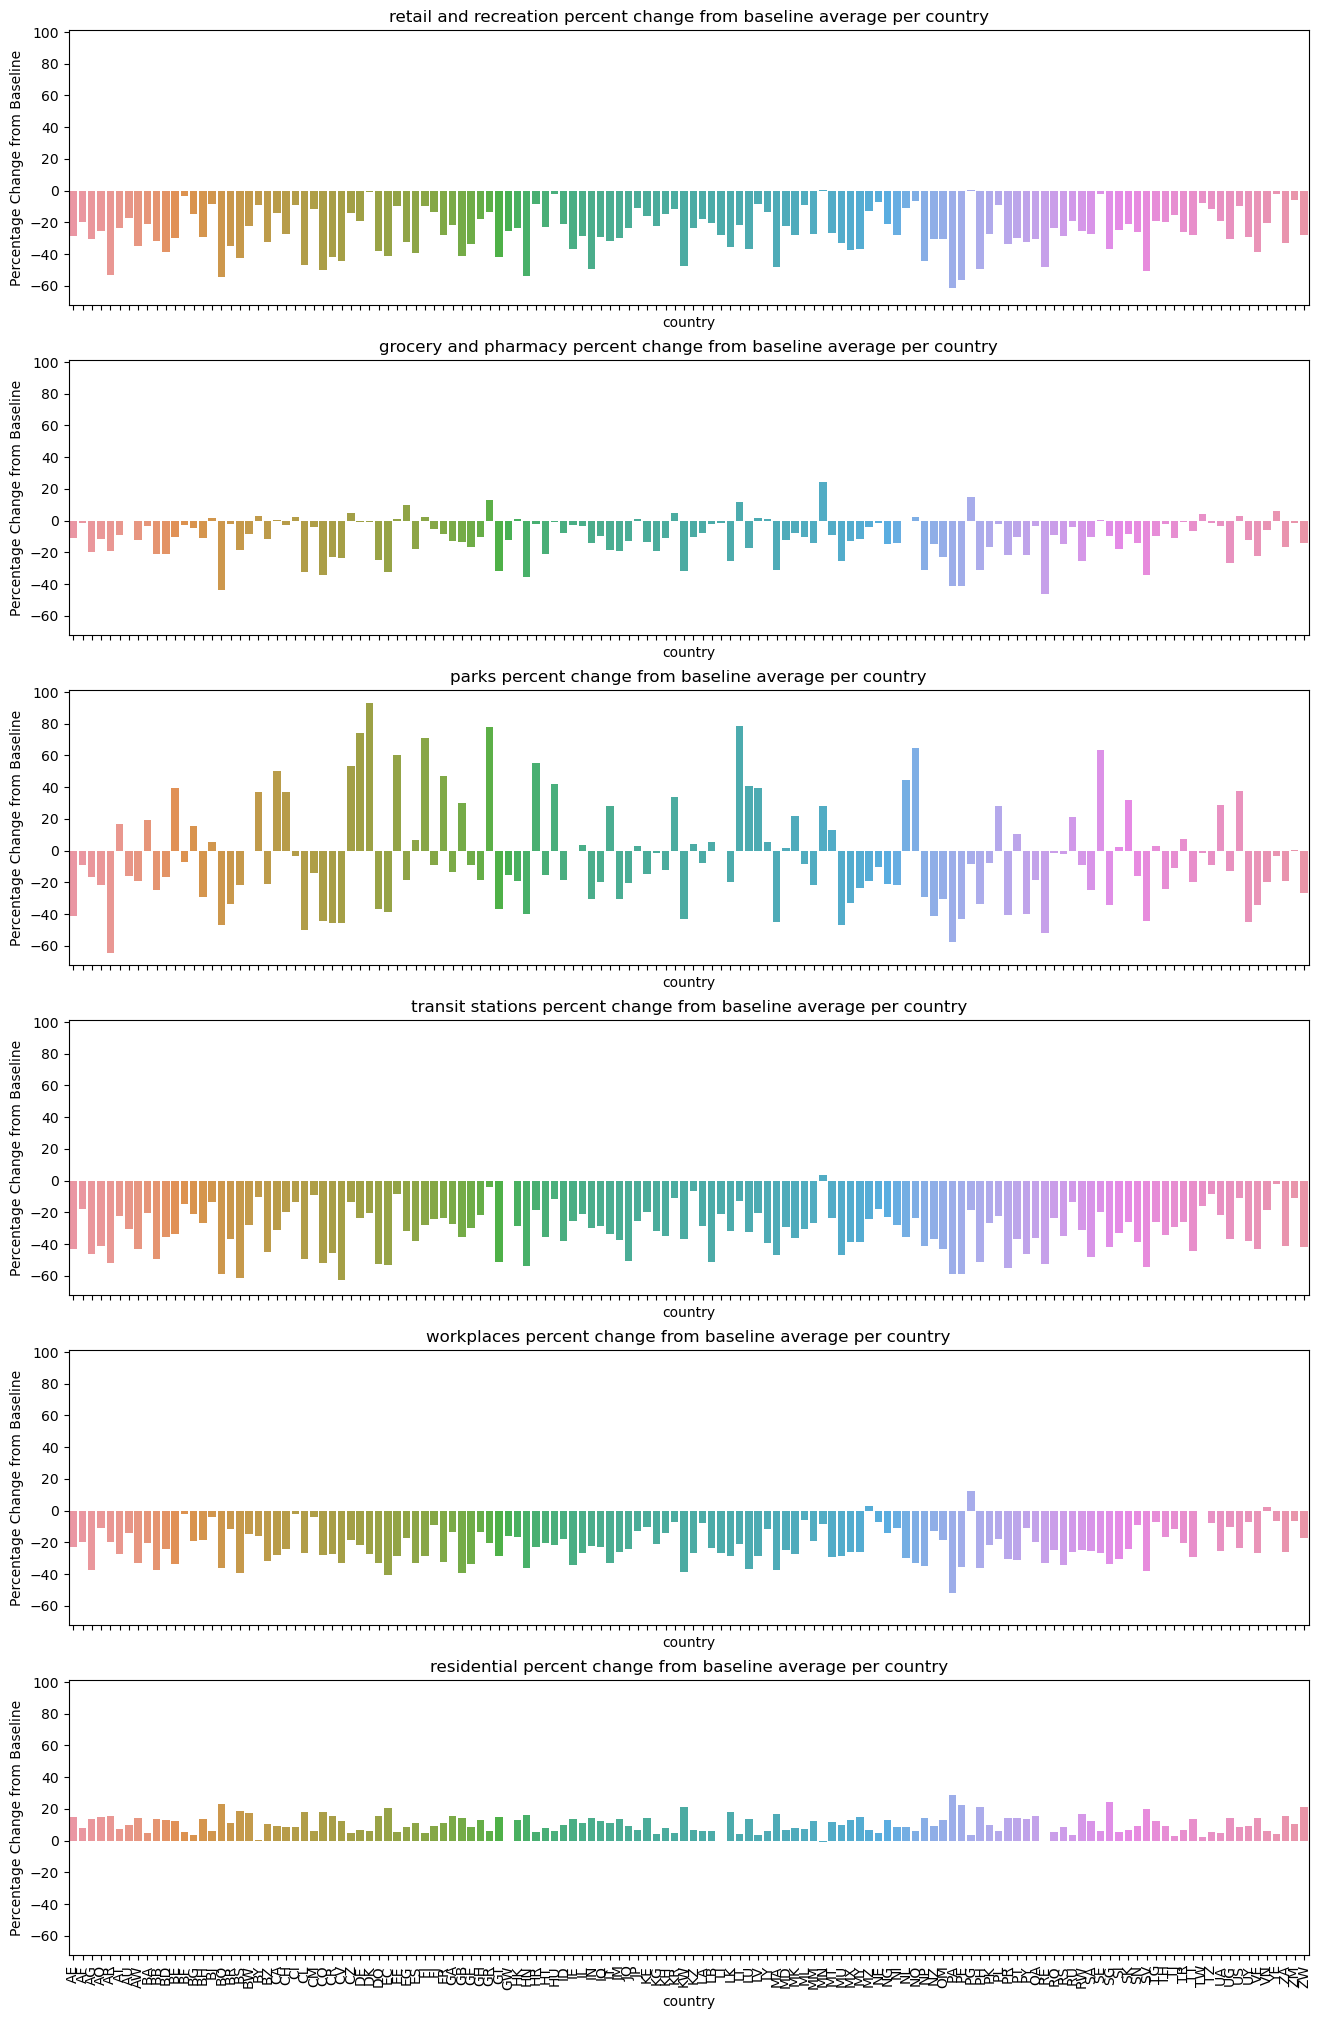

In [28]:
fig, axs= plt.subplots(6,1,sharey=True,sharex=True,figsize=(16,25))
for i, col in enumerate(global_agg.columns):
    ax=axs[i]
    sns.barplot(y=global_agg[col],x=global_agg.index,ax=ax)
    ax.set_xlabel('country')
    ax.set_ylabel('Percentage Change from Baseline')
    ax.set_xticklabels(global_agg.index,rotation=90)
    ax.set_title(str(col).replace('_'," ") + ' average per country')

plt.show()

    

Creating the same barplots, but this time splitting the region codes by continents.

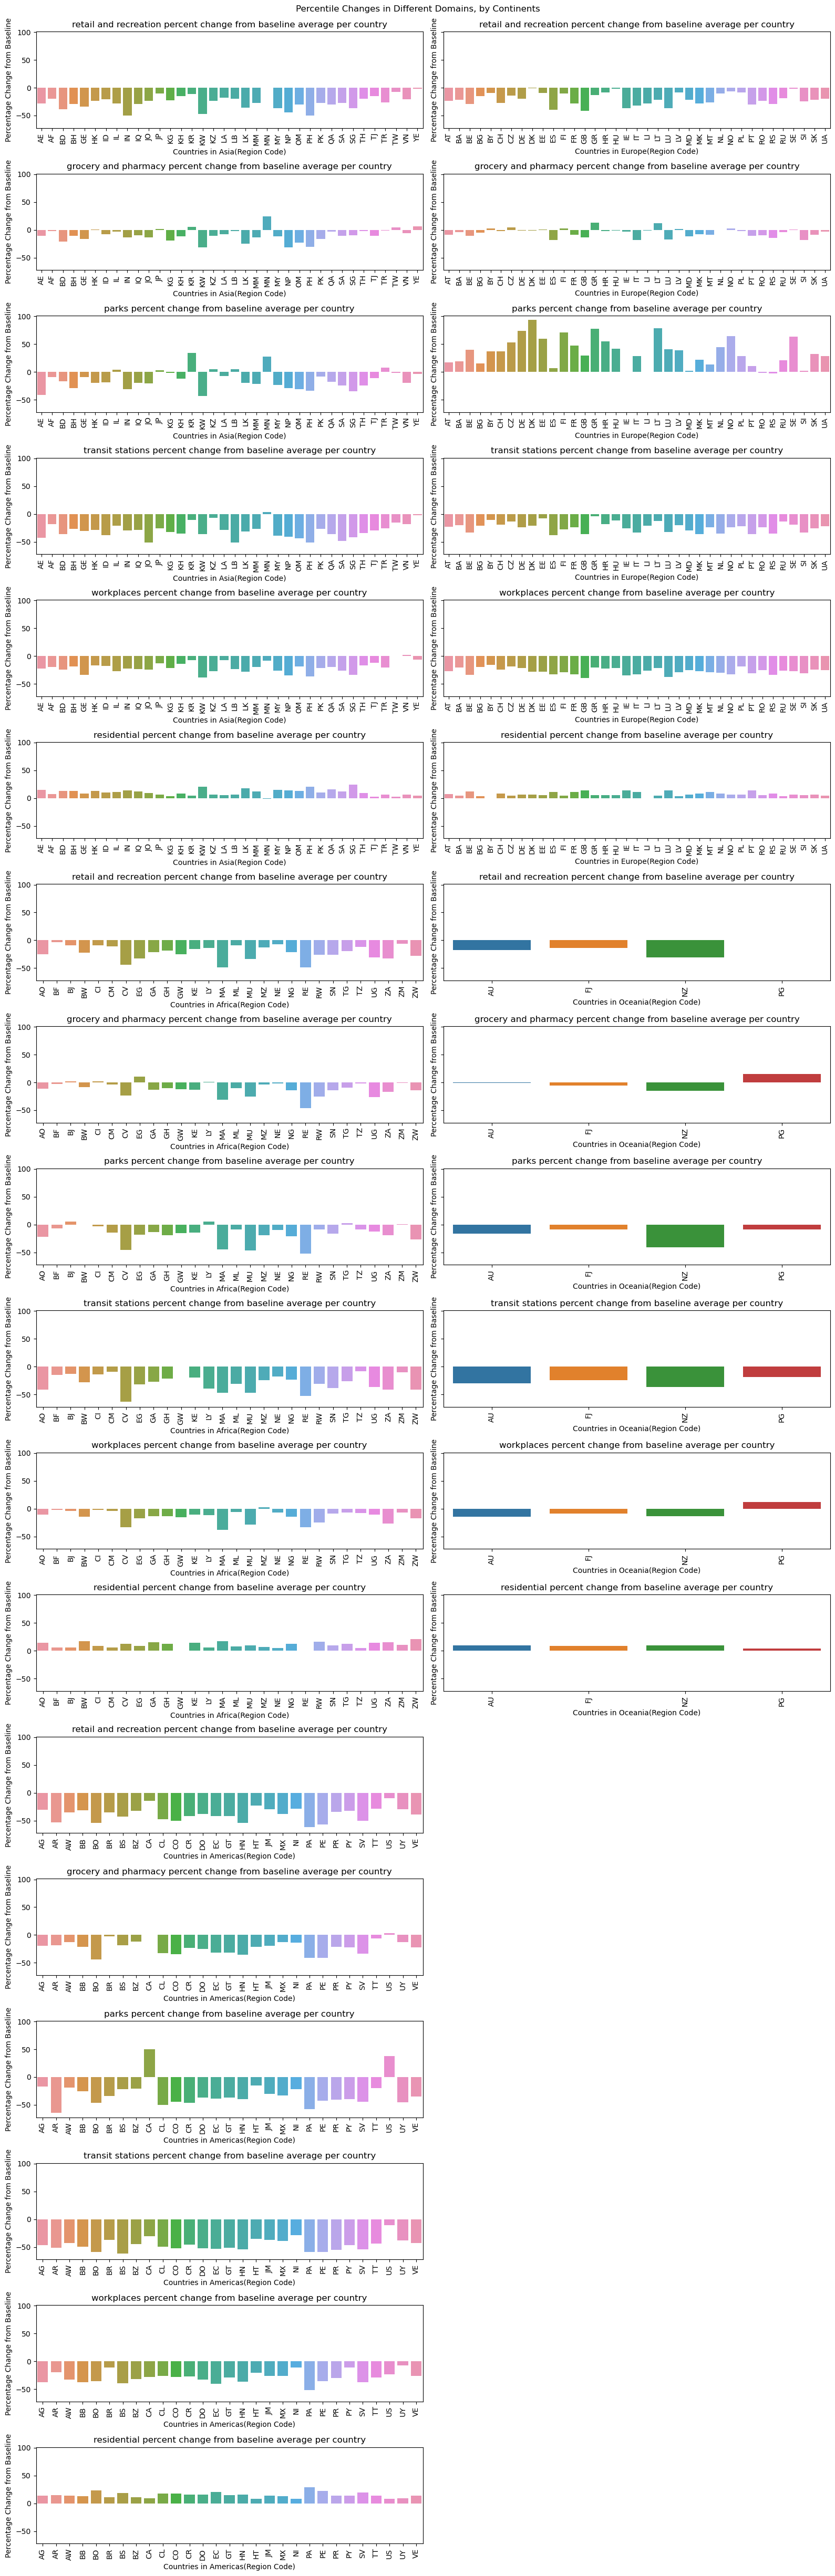

In [29]:
fig, axs= plt.subplots(18,2,sharey=True,sharex=False,figsize=(16,50))
og_columns = global_agg.columns
for j, df  in enumerate(dfsGlobal_agg) :
    df = dfsGlobal_agg[j]
    for i, col in enumerate(og_columns):
        ax=axs[(j//2)*6 + i,j%2]
        sns.barplot(y=df[col],x=df.index,ax=ax)
        ax.set_xlabel('Countries in ' + continents[j] + '(Region Code)')
        ax.set_ylabel('Percentage Change from Baseline')
        ax.set_xticklabels(df.index, rotation=90)
        ax.set_title(str(col).replace('_'," ") + ' average per country')

for i in range (6) : 
    axs[12 + i, 1].set_visible(False)

plt.tight_layout()

# Fine-tune layout to create more space at the top
plt.subplots_adjust(top=0.97)

plt.suptitle('Percentile Changes in Different Domains, by Continents')
plt.show()

# Apple Mobility

In [30]:
apple_mr=pd.read_csv('DATA/applemobilitytrends-2020-04-20.csv')
apple_mr

,geo_type,region,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,...,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20
0,country/region,Albania,driving,100,95.30,101.43,97.20,103.55,112.67,104.83,...,25.47,24.89,32.64,31.43,30.67,30.00,29.26,22.94,24.55,31.51
1,country/region,Albania,walking,100,100.68,98.93,98.46,100.85,100.13,82.13,...,27.63,29.59,35.52,38.08,35.48,39.15,34.58,27.76,27.93,36.72
2,country/region,Argentina,driving,100,97.07,102.45,111.21,118.45,124.01,95.44,...,19.40,12.89,21.10,22.29,23.55,24.40,27.17,23.19,14.54,26.67
3,country/region,Argentina,walking,100,95.11,101.37,112.67,116.72,114.14,84.54,...,15.75,10.45,16.35,16.66,17.42,18.18,18.80,17.03,10.59,18.44
4,country/region,Australia,driving,100,102.98,104.21,108.63,109.08,89.00,99.35,...,26.95,31.72,53.14,55.91,56.56,58.77,47.51,36.90,53.34,56.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,city,Washington DC,transit,100,100.78,103.92,105.02,112.26,96.01,87.76,...,16.99,14.23,17.01,17.37,17.02,17.10,17.14,16.61,16.66,18.20
391,city,Washington DC,walking,100,99.07,109.61,104.16,123.16,119.71,106.28,...,44.63,32.84,33.58,37.56,38.69,37.76,42.50,41.80,43.51,41.89
392,city,Zurich,driving,100,102.38,110.84,105.48,113.83,109.67,102.03,...,63.78,54.97,67.09,72.52,74.89,77.13,78.01,73.62,71.97,73.74
393,city,Zurich,transit,100,101.51,108.93,97.87,103.91,98.50,93.83,...,29.18,31.49,32.90,35.71,35.68,33.65,36.77,36.75,37.66,37.50


Create a new dataframe where we subtract 100 from all values, in order to show the relative change from the baseline

In [31]:
columnsExcluded = ['geo_type', 'region', 'transportation_type']

apple_mr_copy = apple_mr.copy()

apple_mr_copy.iloc[:, ~apple_mr_copy.columns.isin(columnsExcluded)] = apple_mr_copy.loc[:, ~apple_mr_copy.columns.isin(columnsExcluded)] -100
apple_mr_copy

,geo_type,region,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,...,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20
0,country/region,Albania,driving,0,-4.70,1.43,-2.80,3.55,12.67,4.83,...,-74.53,-75.11,-67.36,-68.57,-69.33,-70.00,-70.74,-77.06,-75.45,-68.49
1,country/region,Albania,walking,0,0.68,-1.07,-1.54,0.85,0.13,-17.87,...,-72.37,-70.41,-64.48,-61.92,-64.52,-60.85,-65.42,-72.24,-72.07,-63.28
2,country/region,Argentina,driving,0,-2.93,2.45,11.21,18.45,24.01,-4.56,...,-80.60,-87.11,-78.90,-77.71,-76.45,-75.60,-72.83,-76.81,-85.46,-73.33
3,country/region,Argentina,walking,0,-4.89,1.37,12.67,16.72,14.14,-15.46,...,-84.25,-89.55,-83.65,-83.34,-82.58,-81.82,-81.20,-82.97,-89.41,-81.56
4,country/region,Australia,driving,0,2.98,4.21,8.63,9.08,-11.00,-0.65,...,-73.05,-68.28,-46.86,-44.09,-43.44,-41.23,-52.49,-63.10,-46.66,-43.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,city,Washington DC,transit,0,0.78,3.92,5.02,12.26,-3.99,-12.24,...,-83.01,-85.77,-82.99,-82.63,-82.98,-82.90,-82.86,-83.39,-83.34,-81.80
391,city,Washington DC,walking,0,-0.93,9.61,4.16,23.16,19.71,6.28,...,-55.37,-67.16,-66.42,-62.44,-61.31,-62.24,-57.50,-58.20,-56.49,-58.11
392,city,Zurich,driving,0,2.38,10.84,5.48,13.83,9.67,2.03,...,-36.22,-45.03,-32.91,-27.48,-25.11,-22.87,-21.99,-26.38,-28.03,-26.26
393,city,Zurich,transit,0,1.51,8.93,-2.13,3.91,-1.50,-6.17,...,-70.82,-68.51,-67.10,-64.29,-64.32,-66.35,-63.23,-63.25,-62.34,-62.50


Split the original dataset into different datasets based on the transportation type.

In [32]:
transportationType = apple_mr_copy['transportation_type'].unique()

dfsApple = []

for transport in transportationType :
    dfsApple.append(apple_mr_copy[apple_mr_copy['transportation_type'] == transport].copy())

Calculate the average of each column in order to have a worldwide analysis.

In [33]:
# Remove the first three columns for the dataframes since they don't contain any values
dfsAppleVals = []
for df in dfsApple :
    dfCopy = df.copy()
    dfCopy = dfCopy.loc[:, ~dfCopy.columns.isin(columnsExcluded)]
    dfsAppleVals.append(dfCopy)

# Calculate Averages of Columns of each dataframe
dfsAvgs = []
for df in dfsAppleVals :
    dfsAvgs.append(df.mean().copy())

Study Case : Worldwide By Averaging.

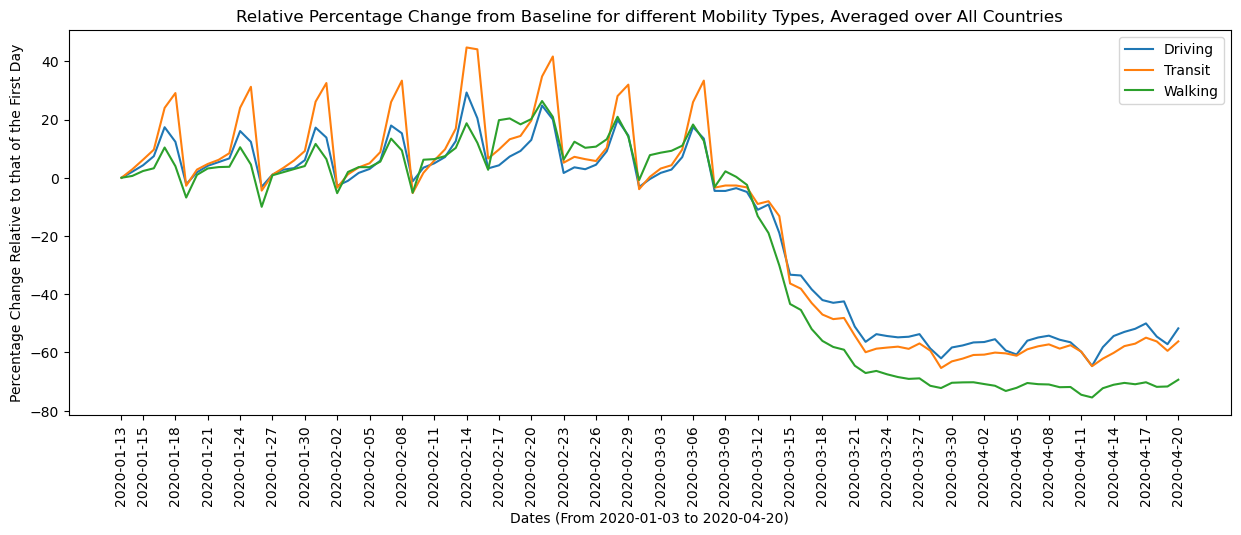

In [34]:
dates = apple_mr_copy.columns
dates = dates[3:]

dates_mod = dates[(np.arange(len(dates)) + 1) % 3 == 0]

dates_mod = dates_mod.insert(0, dates[0])

plt.figure(figsize=(15,5))
sns.lineplot(x=dates, y=dfsAvgs[0], label= 'Driving')
sns.lineplot(x=dates, y=dfsAvgs[1], label= 'Transit')
sns.lineplot(x=dates, y=dfsAvgs[2], label= 'Walking')
plt.xticks(rotation=90)
plt.xticks(dates_mod)
plt.xlabel('Dates (From 2020-01-03 to 2020-04-20)')
plt.ylabel('Percentage Change Relative to that of the First Day')

plt.legend()

plt.title('Relative Percentage Change from Baseline for different Mobility Types, Averaged over All Countries')
plt.show()

Study case : Italy. This is particularly intersting since we can combine this analysis with the one we did for the 'interventions' dataset, and observe the correlation between the date of these interventions and the evolution of the usage of these different mobility types.

In [35]:
# Adapting the timestamp variables from the interventions datasets in order to implement them in the following graphs

itLockdown = interventions['Lockdown'][3].strftime('%Y-%m-%d %H:%M:%S')
itLockdown = itLockdown.replace(" 00:00:00", "")
itNormalcy = interventions['Normalcy'][3].strftime('%Y-%m-%d %H:%M:%S')
itNormalcy = itNormalcy.replace(" 00:00:00", "")
it1stCase = interventions['1st case'][3].strftime('%Y-%m-%d %H:%M:%S')
it1stCase = it1stCase.replace(" 00:00:00", "")

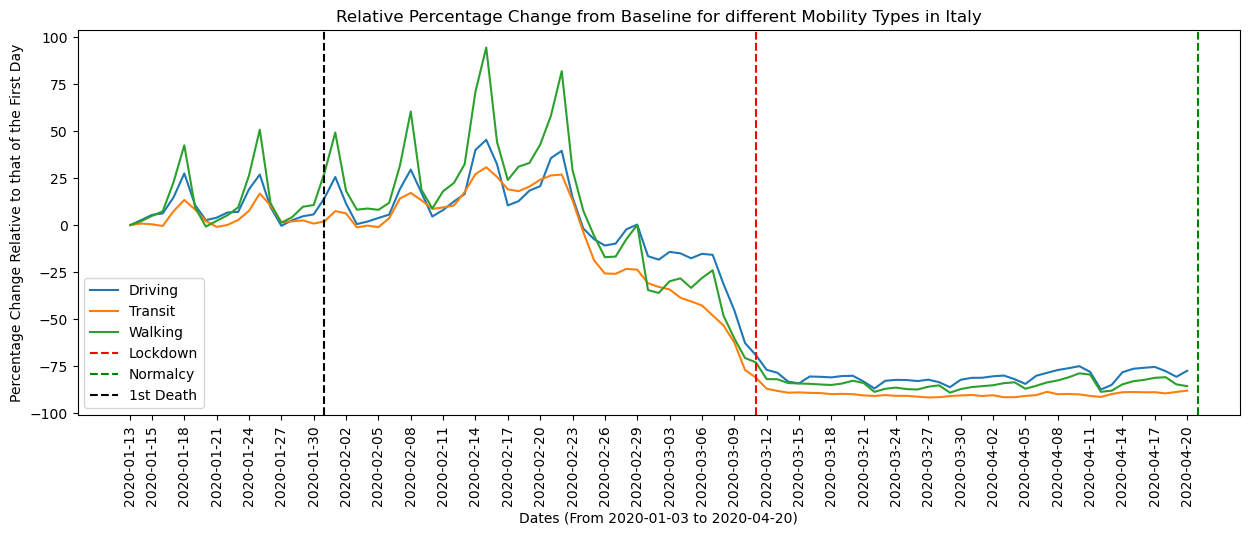

In [71]:
apple_italy = apple_mr_copy[apple_mr_copy['region'] == 'Italy'].copy()
apple_italy = apple_italy.iloc[:, ~apple_italy.columns.isin(columnsExcluded)]

 
plt.figure(figsize=(15,5))
sns.lineplot(x=dates, y=apple_italy.values[0], label= 'Driving')
sns.lineplot(x=dates, y=apple_italy.values[1], label= 'Transit')
sns.lineplot(x=dates, y=apple_italy.values[2], label= 'Walking')
plt.xticks(rotation=90)
plt.xticks(dates_mod)

plt.axvline(x=itLockdown,color='red', linestyle='--', label='Lockdown')
plt.axvline(x=itNormalcy,color='green', linestyle='--', label='Normalcy')
plt.axvline(x=it1stCase,color='black', linestyle='--', label='1st Death')
plt.xlabel('Dates (From 2020-01-03 to 2020-04-20)')
plt.ylabel('Percentage Change Relative to that of the First Day')
plt.legend()

plt.title('Relative Percentage Change from Baseline for different Mobility Types in Italy')
plt.show()

Case Study : All countries within the interventions dataset.

In [37]:
interventions['lang']

0     fr
1     da
2     de
3     it
4     nl
5     no
6     sr
7     sv
8     ko
9     ca
10    fi
11    ja
12    en
Name: lang, dtype: string

In [38]:
countriesInter = ['France',
                  'Denmark',
                  'Germany',
                  'Italy',
                  'Netherlands',
                  'Norway',
                  'Sweden',
                  'Canada',
                  'Finland',
                  'Japan',
                  'UK']


11

In [67]:
# for i, country in enumerate(countriesInter) :
#     lockdown_timestamp = interventions['Lockdown'][i]
    
#     # Check if the timestamp is not NaT before formatting
#     if pd.notna(lockdown_timestamp):
#         print('Country : ', country,  ' SUiiii')
#     else : print('Country : ', country,'NOOOOOOO')


Country :  France  SUiiii
Country :  Denmark  SUiiii
Country :  Germany  SUiiii
Country :  Italy  SUiiii
Country :  Netherlands NOOOOOOO
Country :  Norway  SUiiii
Country :  Sweden  SUiiii
Country :  Canada NOOOOOOO
Country :  Finland NOOOOOOO
Country :  Japan  SUiiii
Country :  UK NOOOOOOO


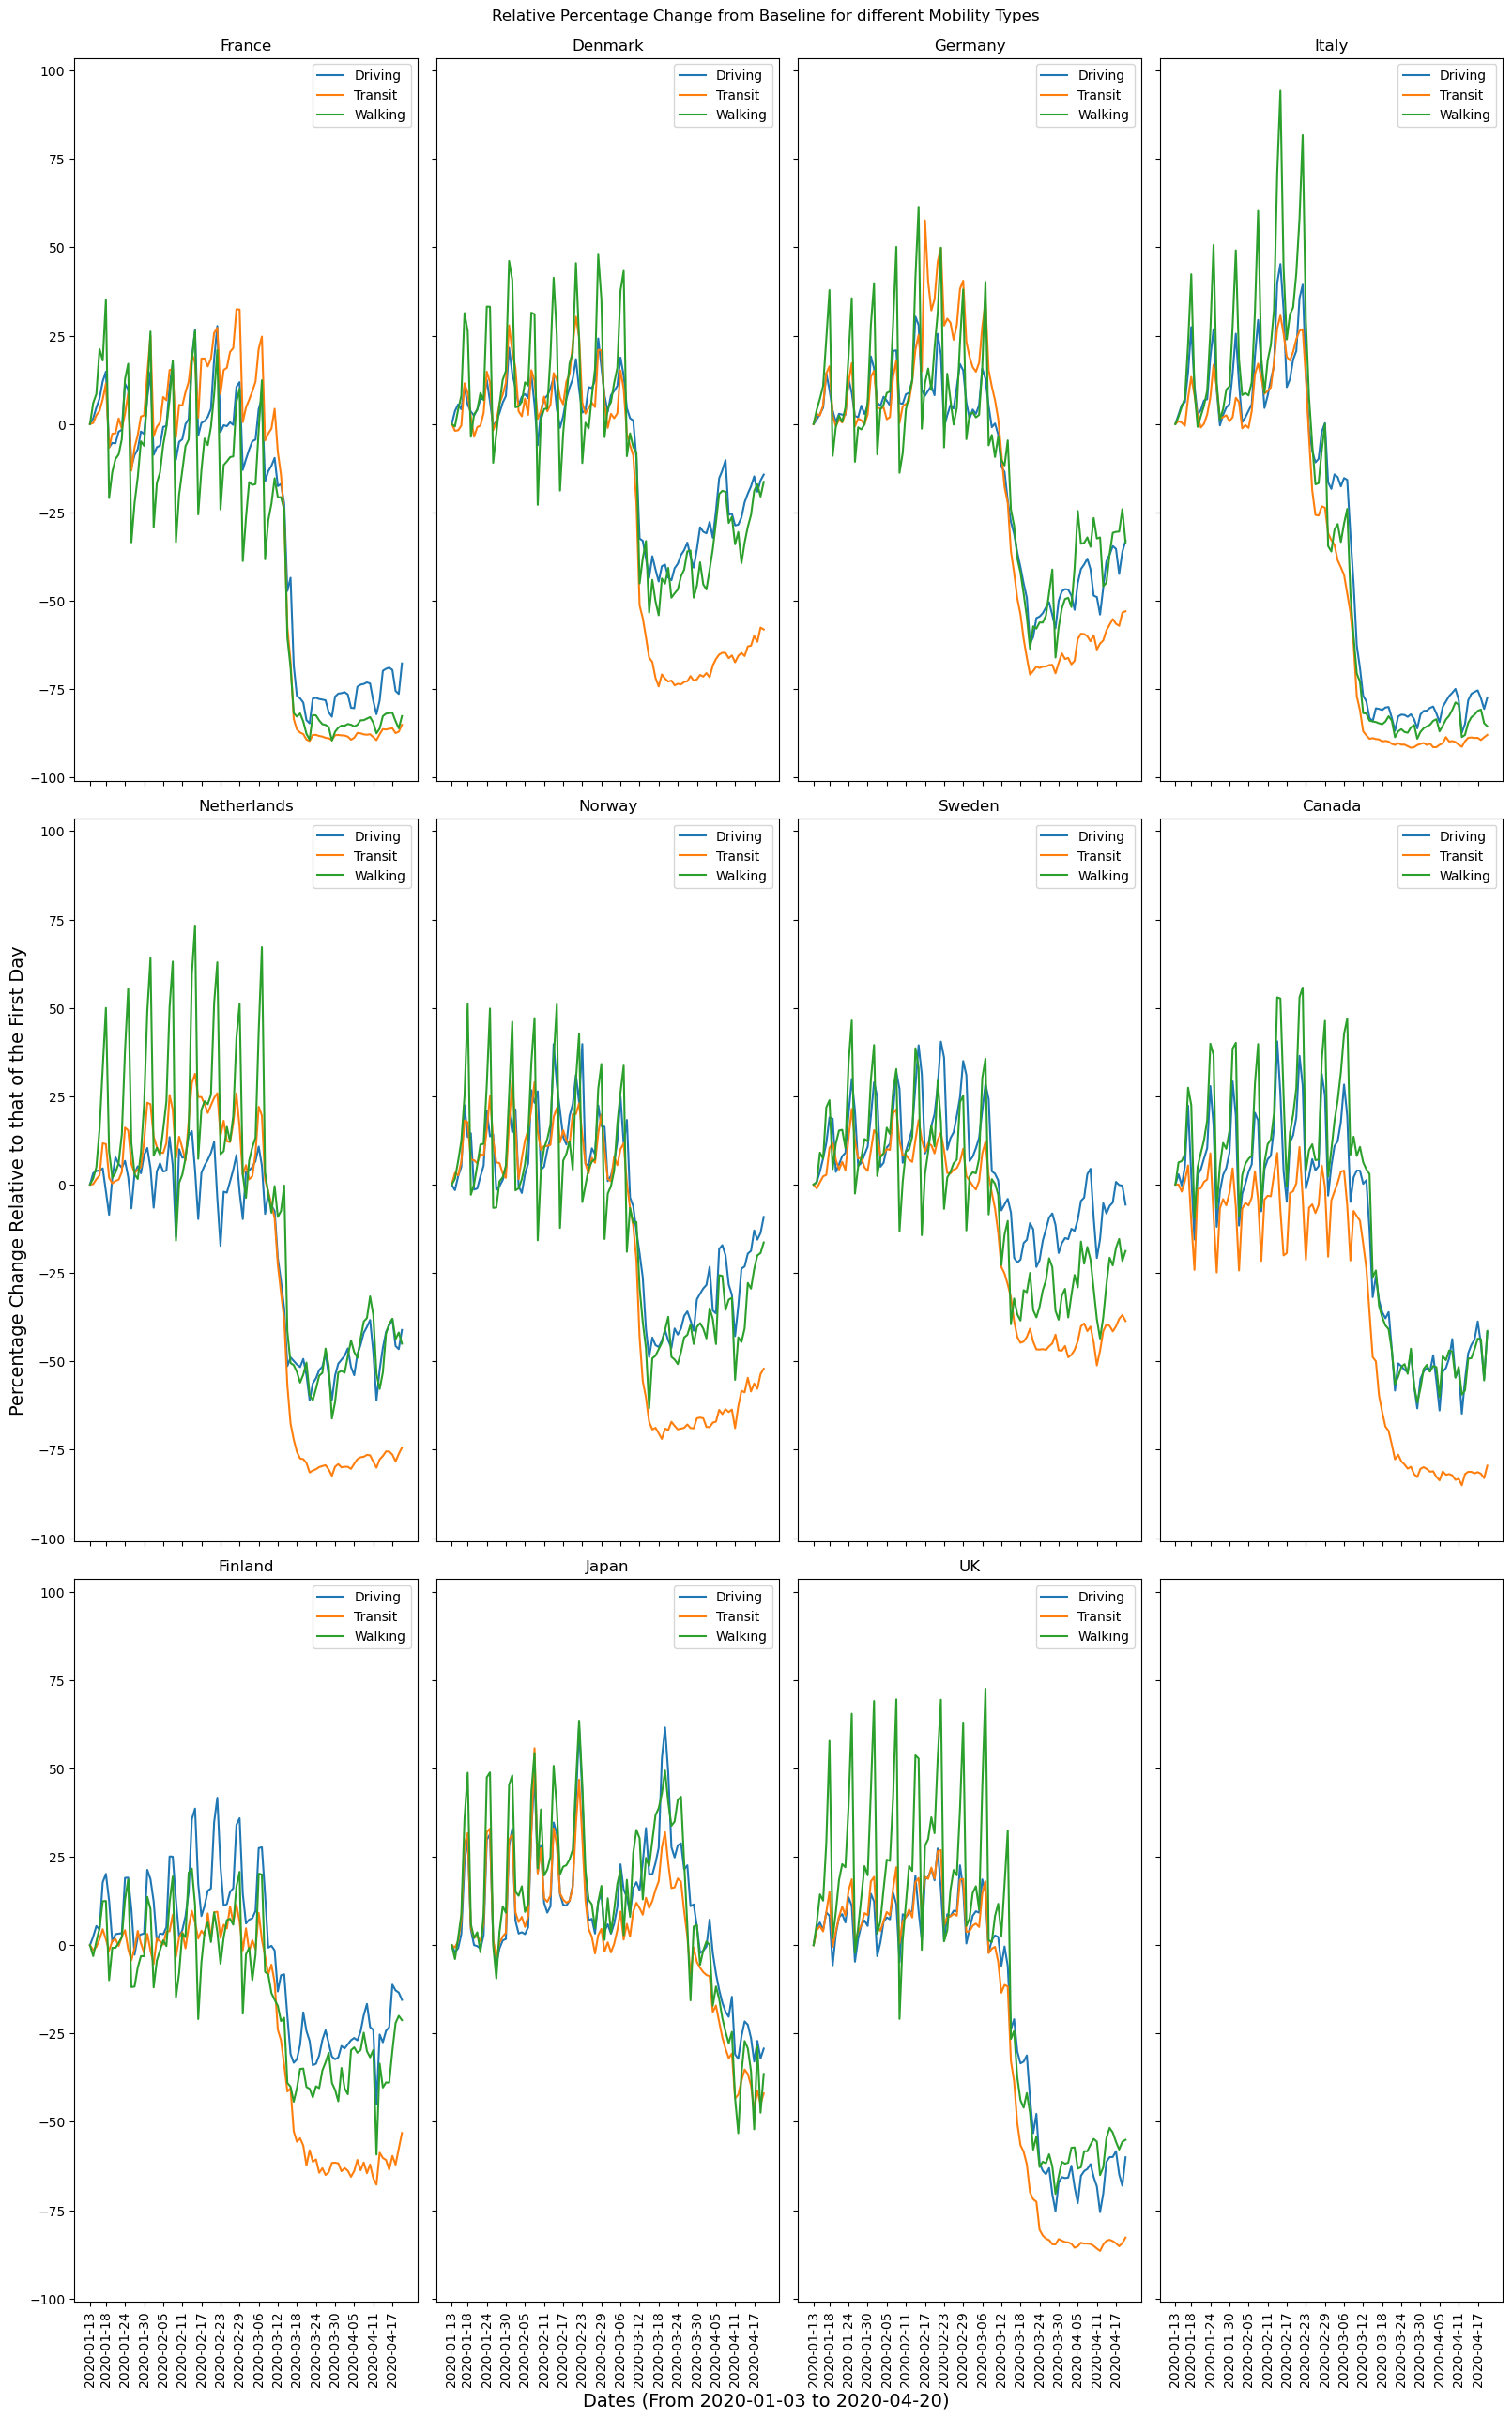

In [74]:
dates_mod2 = dates[(np.arange(len(dates)) + 1) % 6 == 0]

dates_mod2 = dates_mod2.insert(0, dates[0])


fig, axs= plt.subplots(3, 4, sharey=True, sharex=True, figsize=(16,26))

for i, country in enumerate(countriesInter) :
    # lockdown = interventions['Lockdown'][i].strftime('%Y-%m-%d %H:%M:%S')
    # lockdown = lockdown.replace(" 00:00:00", "")
    # normalcy = interventions['Normalcy'][i].strftime('%Y-%m-%d %H:%M:%S')
    # normalcy = normalcy.replace(" 00:00:00", "")
    # firstCase = interventions['1st case'][i].strftime('%Y-%m-%d %H:%M:%S')
    # firstCase = firstCase.replace(" 00:00:00", "")

    dfAppleCurrent = apple_mr_copy[apple_mr_copy['region'] == country].copy()
    dfAppleCurrent = dfAppleCurrent.iloc[:, ~dfAppleCurrent.columns.isin(columnsExcluded)]

    ax = axs[i//4, i%4]
    sns.lineplot(x=dates, y=dfAppleCurrent.values[0], label= 'Driving', ax=ax)
    sns.lineplot(x=dates, y=dfAppleCurrent.values[1], label= 'Transit', ax=ax)
    sns.lineplot(x=dates, y=dfAppleCurrent.values[2], label= 'Walking', ax=ax)
    ax.set_xticks(dates_mod2)
    ax.set_xticklabels(labels= dates_mod2,rotation=90)    
    # ax.axvline(x=lockdown,color='red', linestyle='--', label='Lockdown')
    # ax.axvline(x=normalcy,color='green', linestyle='--', label='Normalcy')
    # ax.axvline(x=firstCase,color='black', linestyle='--', label='1st Death')
    ax.set_title(country)

axs[2, 3].set_xticklabels(labels= dates_mod2,rotation=90)
# axs[2, 3].set_visible(False)

fig.text(0.5, 0.00000005, 'Dates (From 2020-01-03 to 2020-04-20)', ha='center', va='center', fontsize=14)
fig.text(0.002, 0.5, 'Percentage Change Relative to that of the First Day', ha='center', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()

# Fine-tune layout to create more space at the top
plt.subplots_adjust(top=0.96)

plt.suptitle('Relative Percentage Change from Baseline for different Mobility Types')
plt.show()